### Auto Regressive Integratred Moving Average (ARIMA) Model
ARIMA model can be used to predict the future values based on its own past values, that is, its own lags (Auto Regressive)  and the lagged forecast errors (Moving Average). [Complete Guide in this link](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values). Also refer to this [Youtube link about ARIMA Models for Stock Price Prediciton](https://www.youtube.com/watch?v=gqryqIlvEoM&ab_channel=DecisionForest) for clear explanation.

Here we use it for forecasting stock price with the same dataset used in the xgboost for time series forecasting in another notebook in this repository.

#### Importing Extensions and  main Libraries
I will be importing libraries in the notebook cell as needed to make it clear where it is exactly needed.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%load_ext lab_black

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

import warnings

warnings.filterwarnings("ignore")

plt.style.use(style="seaborn")
%matplotlib inline

# make autocomplet working
%config Completer.use_jedi = False

In [3]:
# data is microsoft's past 5 year daily stock price (April 10 2020 - April 10 2021)
data_url = "https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1460246400&period2=1618012800&interval=1d&events=history&includeAdjustedClose=true"
data = pd.read_csv(data_url)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-11,54.490002,55.150002,54.299999,54.310001,49.800735,21414200
1,2016-04-12,54.369999,54.779999,53.759998,54.650002,50.112518,24944300
2,2016-04-13,55.119999,55.439999,54.889999,55.349998,50.754379,20818000
3,2016-04-14,55.220001,55.580002,55.070000,55.360001,50.763554,20877100
4,2016-04-15,55.299999,55.919998,55.110001,55.650002,51.029476,28793800
...,...,...,...,...,...,...,...
1254,2021-04-05,242.759995,249.960007,242.699997,249.070007,249.070007,36910600
1255,2021-04-06,247.610001,249.399994,246.880005,247.860001,247.860001,22931900
1256,2021-04-07,247.809998,250.929993,247.190002,249.899994,249.899994,22719800
1257,2021-04-08,252.770004,254.139999,252.000000,253.250000,253.250000,23625200


In [4]:
# making it univariate time series problem, we are taking the Closing price to predict
df = data[["Close"]].round(2).copy()
print(df.shape)
df.head()

(1259, 1)


,Close
0,54.31
1,54.65
2,55.35
3,55.36
4,55.65


In [5]:
df.describe()

,Close
count,1259.000000
mean,120.070731
std,55.604813
min,48.430000
25%,71.860000
50%,106.810000
75%,154.975000
max,255.850000


##### ARIMA model is characterized by 3 terms: p,d and q
- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

**If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’**

#### lets find d first
- The purpose of differencing is to make the time series stationary. Differencing is only needed if the series is non-stationary.
- [Augmented Dickey Fuller (ADF)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) can be used to check if the series is stationary or not. 
- The null hypothesis of the **ADF test** is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary. So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [6]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.4095749174929415
p-value: 0.9971572080691912


Since, the values is greater, lets difference the series and see how the auto-correlation plot looks like using **Autocorrelation Function (ACF)**

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

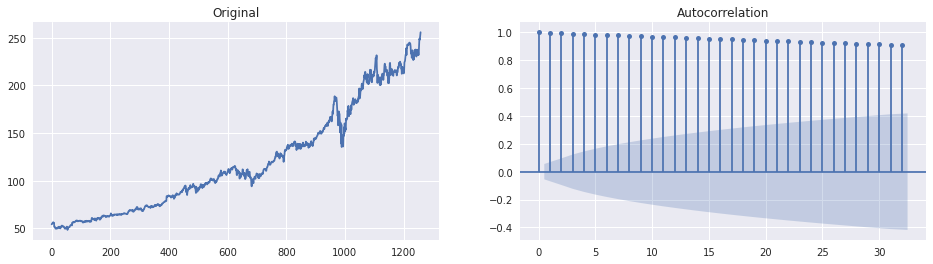

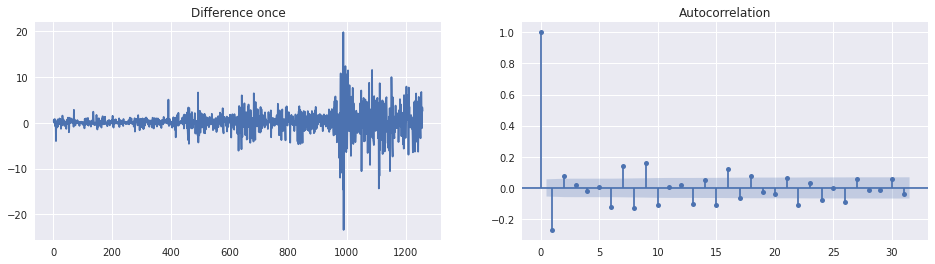

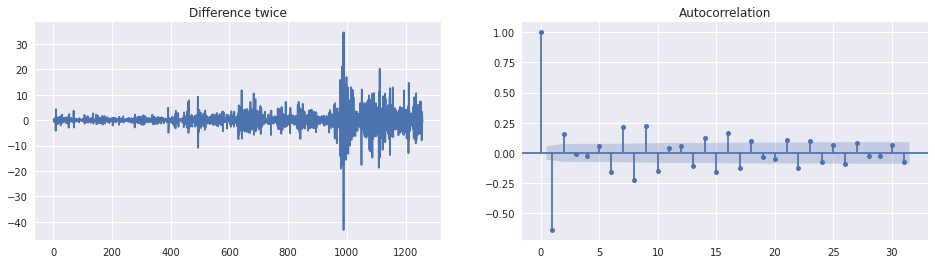

In [24]:
# # add ; at the end of the plot function so that the plot is not duplicated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

# 1st Differencing
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

# 2nd Differencing
diff = df.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

It can be difficult to analyze the plot, so lets use `pmdarima package` to get the number of indexing. [pmdarima docs](http://alkaline-ml.com/pmdarima/modules/classes.html)

In [9]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.Close, test="adf")

1

Ok, so according to pmdarima, lets use the value of d as 1.

#### Now, lets find p
p in ARIMA model is the order of the Auto Regressive (AR) term which refers to lags to be used as predictors. This can be calculated by inspecting the partial Autocorrelation (PACF) plot.

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

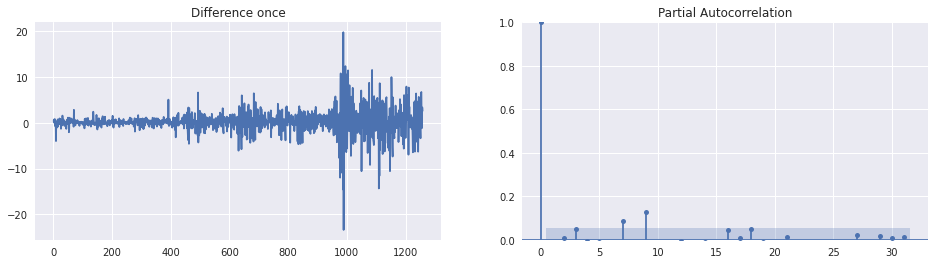

In [25]:
# PACF plot of 1st differenced series
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 7 is quite signigicant since is well above the significance line. We can take other points and try to check the result.

#### Now, lets find q 
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model. We can look at the ACF plot for the number of MA terms.

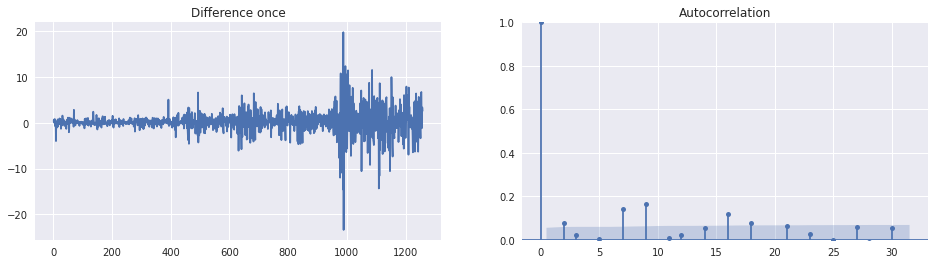

In [26]:
# lets see autocorrelation plot of the 1st differenced series
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

Couple of lags are well abvoe the significane line, but I am going with 2.

### Fitting the ARIMA model

In [13]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
# 7,1,2 = p,d,w ARIMA Model
model = ARIMA(df.Close, order=(7, 1, 2))
result = model.fit(disp=0)

In [15]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1258
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -2890.955
Method:                       css-mle   S.D. of innovations              2.408
Date:                Sat, 10 Apr 2021   AIC                           5803.909
Time:                        16:35:57   BIC                           5860.419
Sample:                             1   HQIC                          5825.146
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1592      0.054      2.970      0.003       0.054       0.264
ar.L1.D.Close    -1.9711      0.073    -27.047      0.000      -2.114      -1.828
ar.L2.D.Close    -1.2343      0.097    -

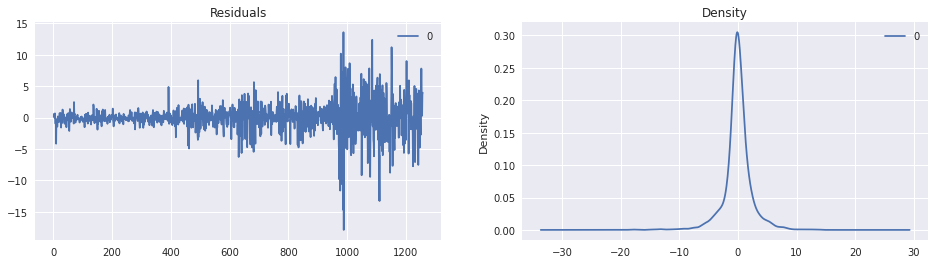

In [16]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values. When we set `dynamic=False` the in-sample lagged values are used for prediction.

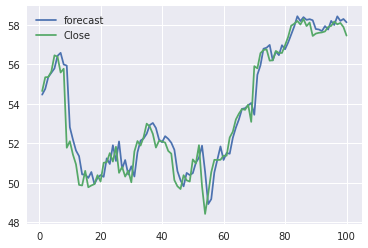

In [17]:
# Actual vs Fitted
result.plot_predict(start=1, end=100, dynamic=False)
plt.show()

After this plot, it looks that the model predicts good output but is it the best ? We can't say that at this point because we haven't forecasted into the future and compare the forecast and the actual performance. Let's use out-of-time cross validation to achieve that.

#### Optimal ARIMA model manually using Out-of-Time Cross Valiation
Steps that needs to be taken for this approach.
- Split the data into train test. 
- Lets do 80:20 ratio and the splitting must be continuous (not random/shuffling) because the order sequence of the time series should be intact in order to use it for forecasting.

In [18]:
# train test split
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]
print(len(train), len(test))

1007 252


In [19]:
step = 30

model = ARIMA(train, order=(6, 1, 3))
result = model.fit(disp=0)
print(result.summary())

# Forecast
fc, se, conf = result.forecast(step)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1006
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -2040.421
Method:                       css-mle   S.D. of innovations              1.838
Date:                Sat, 10 Apr 2021   AIC                           4102.843
Time:                        16:36:11   BIC                           4156.894
Sample:                             1   HQIC                          4123.380
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1091      0.049      2.210      0.027       0.012       0.206
ar.L1.D.Close    -2.0837      0.353     -5.904      0.000      -2.775      -1.392
ar.L2.D.Close    -1.9102      0.630     

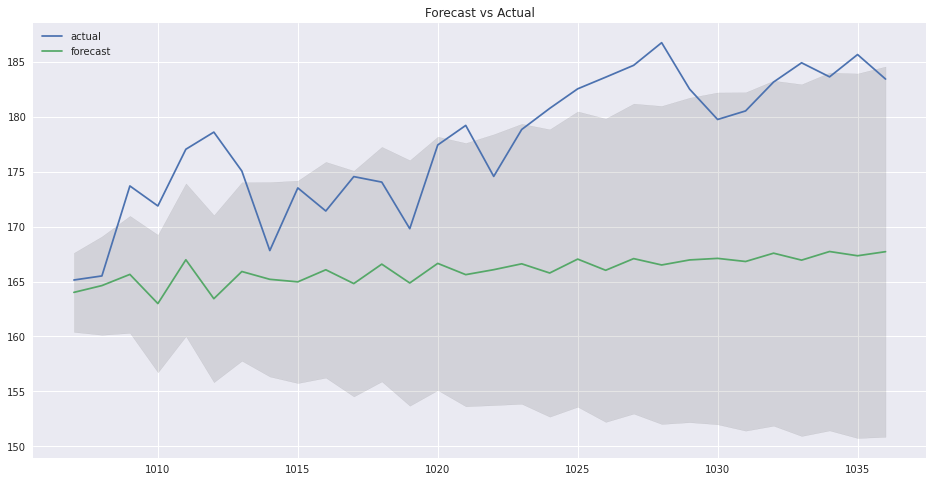

In [20]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")
plt.show()

From the figure above, the forecast direction is correct, the actual observed value more or less lies with the 95% confidence support. But, the predicted forecast is considerably below the actual. More trail and error is needed to make the better forecast.

#### Auto ARIMA
The `pmdarima package` provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC. Lets try this auto ARIMA to see what it captures.

In [21]:
from pmdarima.arima import auto_arima

In [22]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,
    d=None,
    seasonal=False,
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5856.237, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5947.274, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5854.278, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5863.134, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5950.159, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5856.222, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5857.774, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5860.678, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.228 seconds
